<a href="https://colab.research.google.com/github/veereshg36/ml/blob/main/DisasterTweetClassfication/NLP_DisasterTweetsPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/c/nlp-getting-started/overview

In [208]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

%matplotlib inline
plt.rcParams['figure.figsize'] = [10,8]
sns.set()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [179]:
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')

df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [180]:
real_tweets = df_train[df_train['target'] == 1]['text'].sample(10).values
fake_tweets = df_train[df_train['target'] == 0]['text'].sample(10).values


for x in real_tweets:
  print(f"{x}\n")
print("-"*50)
for x in fake_tweets:
  print(f"{x}\n")
  

Families to sue over Legionnaires: More than 40 families affected by the fatal outbreak of Legionnaires' disea... http://t.co/ZA4AXFJSVB

After a suicide bombing in SuruÌ¤ that killed 32 people Turkey launches airstrikes against ISIL and Kurdistan Workers' Party camps in Iraq.

UNPREDICTABLE DISCONNECTED AND SOCIAL CASUALTY ARE MY FAVORITES HOW DO PEOPLE NOT LIKE THEM

#Glimpses: Hyderabad deluged by heavy rainfall | http://t.co/DctV1uJLHc http://t.co/QOx1jNQSAU

He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam

The Cafe Run by Acid Attack Survivors in #India http://t.co/qmiF0bLwOa http://t.co/l6PIf3LpEn

ÛÏ@SplottDave: @TeamPalestina That's about 28700 Palestinian homes demolished now by Israel since 1967 w/ 0 Israeli home demolished @POTUS

connor franta: damn sirens I hope everyone is okay. 

dan howell: can you PLEASE get MURDERED on ANOTHER STREET

ÛÏ@BBCEngland: A burst water main causes major flooding a

# Analysis

Breaking down the constituents of the tweets, we can pull out the following features and see if they have any insights:
1. Length
2. Hashtags 
3. Mentions
4. Links
5. Punctuation

In [181]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Total of 7613 entries.
Dataset has NAs in the keyword and location features. 

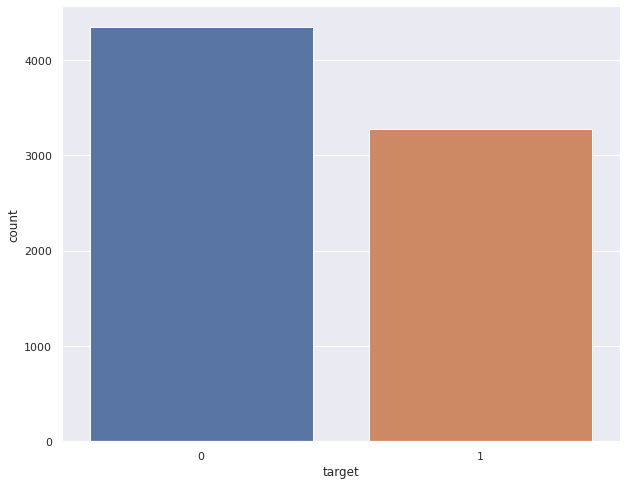

In [182]:
df_train['target'].value_counts()

# plt.figure(figsize=(10,8))
sns.countplot(data = df_train, x = 'target')

No evident imbalance in the classes.


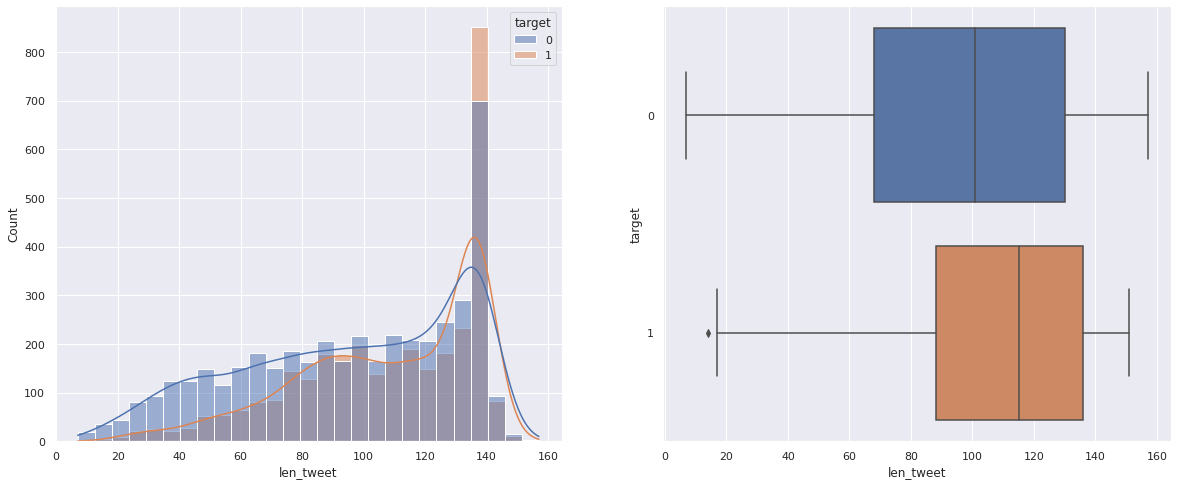

In [183]:
df_train['len_tweet'] = df_train['text'].apply(len)
df_test['len_tweet'] = df_test['text'].apply(len)

# plt.figure(figsize=(10,8))
fig,axes = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data=df_train, x = 'len_tweet', hue='target', ax=axes[0], kde=True)
sns.boxplot(data=df_train, x = 'len_tweet', y='target', orient='h',ax=axes[1])

Tweet length is similarly distributed but on average, real tweets have slightly higher length.

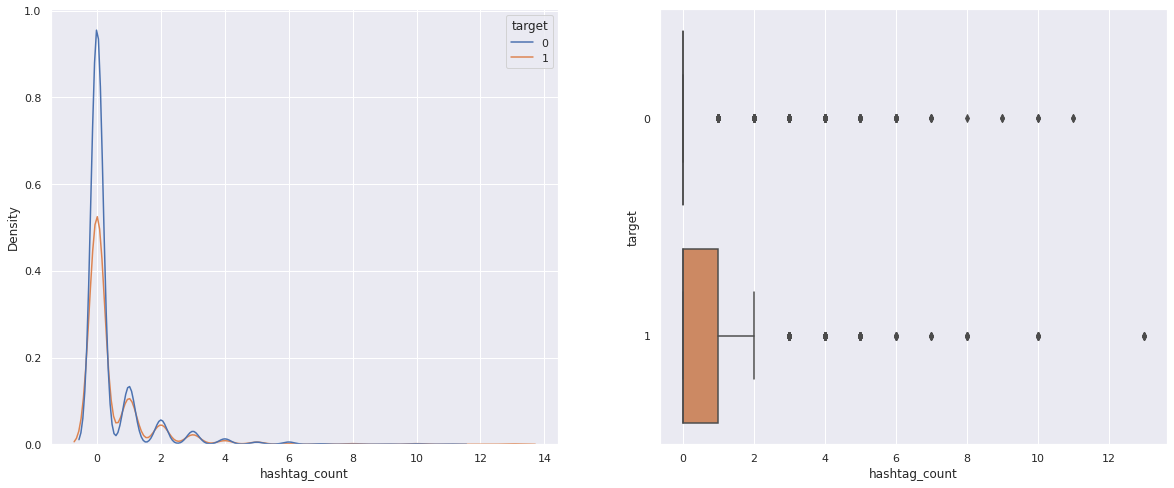

In [184]:
def get_hastags(tweet):
  return tweet.count("#")


df_train['hashtag_count'] = df_train['text'].apply(get_hastags)
df_test['hashtag_count'] = df_test['text'].apply(get_hastags)

fig,axes = plt.subplots(1,2, figsize=(20,8))
sns.kdeplot(data=df_train, x = 'hashtag_count', hue='target', ax=axes[0])
sns.boxplot(data=df_train, x = 'hashtag_count', y='target', orient='h',ax=axes[1])

Observation : No real insight added by this feature.

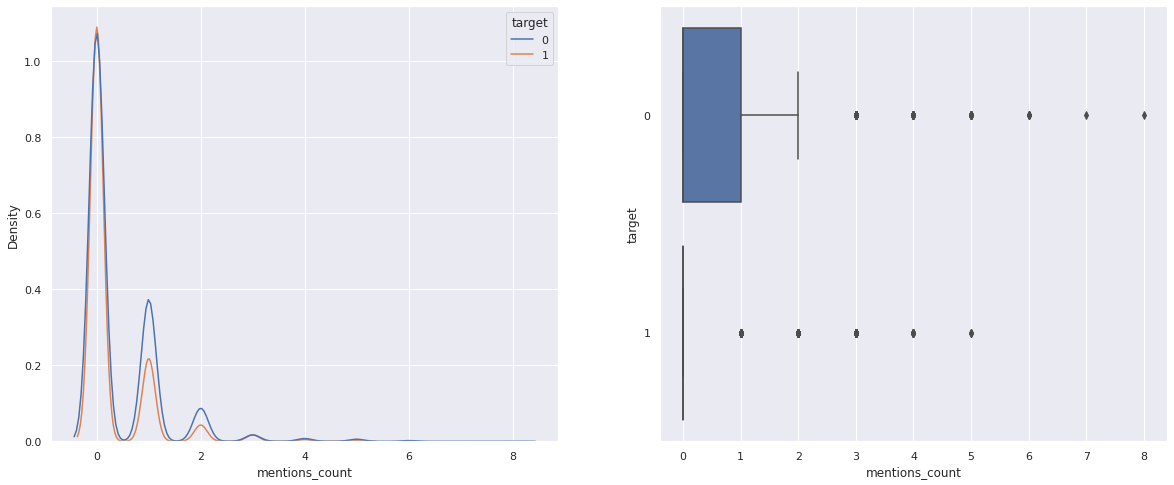

In [185]:
def get_mentions_count(tweet):
  return tweet.count("@")

df_train['mentions_count'] = df_train['text'].apply(get_mentions_count)
df_test['mentions_count'] = df_test['text'].apply(get_mentions_count)

fig,axes = plt.subplots(1,2, figsize=(20,8))
sns.kdeplot(data=df_train, x = 'mentions_count', hue='target', ax=axes[0])
sns.boxplot(data=df_train, x = 'mentions_count', y='target', orient='h',ax=axes[1])

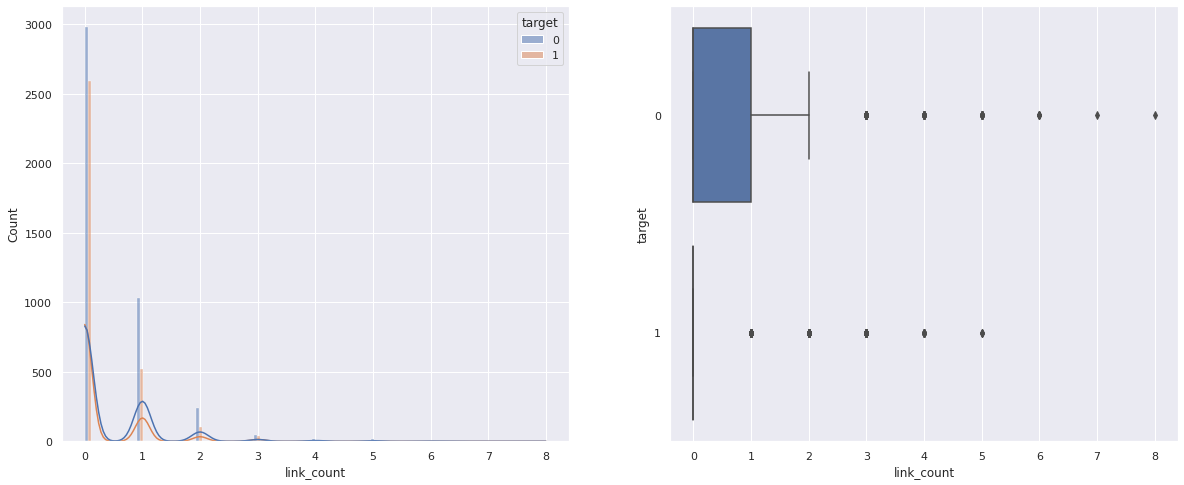

In [213]:
def get_links_count(tweet):
  return tweet.count("http")

df_train['link_count'] = df_train['text'].apply(get_mentions_count)
df_test['link_count'] = df_test['text'].apply(get_mentions_count)

fig,axes = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data=df_train, x = 'link_count', hue='target',  kde=True,multiple="dodge",ax=axes[0])

sns.boxplot(data=df_train, x = 'link_count', y='target', orient='h',ax=axes[1])

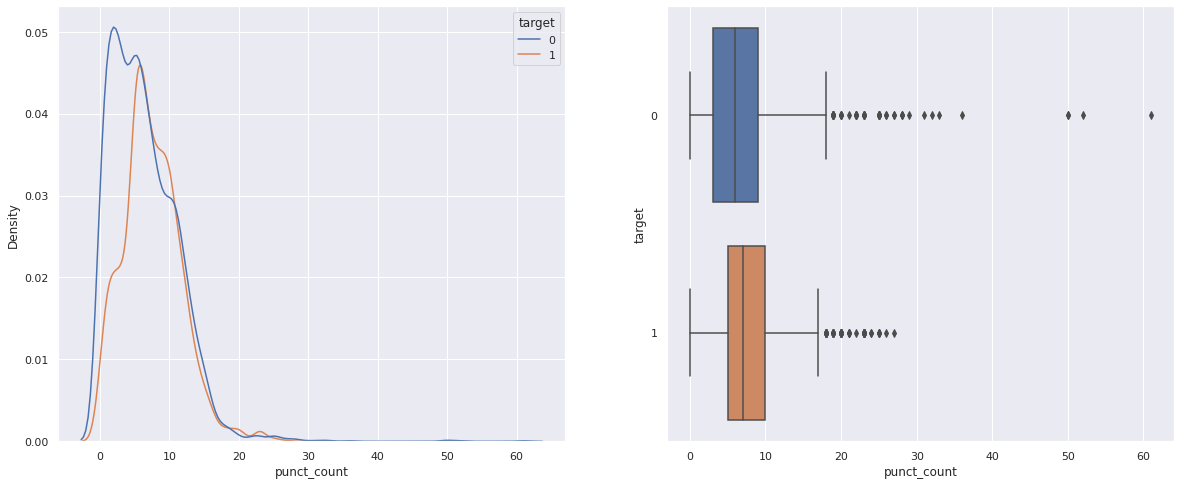

In [187]:
def get_punctuation_count(tweet):
  count = 0
  for c in tweet:
    if(c in string.punctuation):
      count+=1
  
  return count


df_train['punct_count'] = df_train['text'].apply(get_punctuation_count)
df_test['punct_count'] = df_test['text'].apply(get_punctuation_count)


fig,axes = plt.subplots(1,2, figsize=(20,8))
sns.kdeplot(data=df_train, x = 'punct_count', hue='target', ax=axes[0])
# sns.histplot(data=df_train, x = 'punct_count', hue='target', multiple='dodge', ax=axes[0])


sns.boxplot(data=df_train, x = 'punct_count', y='target', orient='h',ax=axes[1])

Observation: Higher number of punctuations in real tweets!

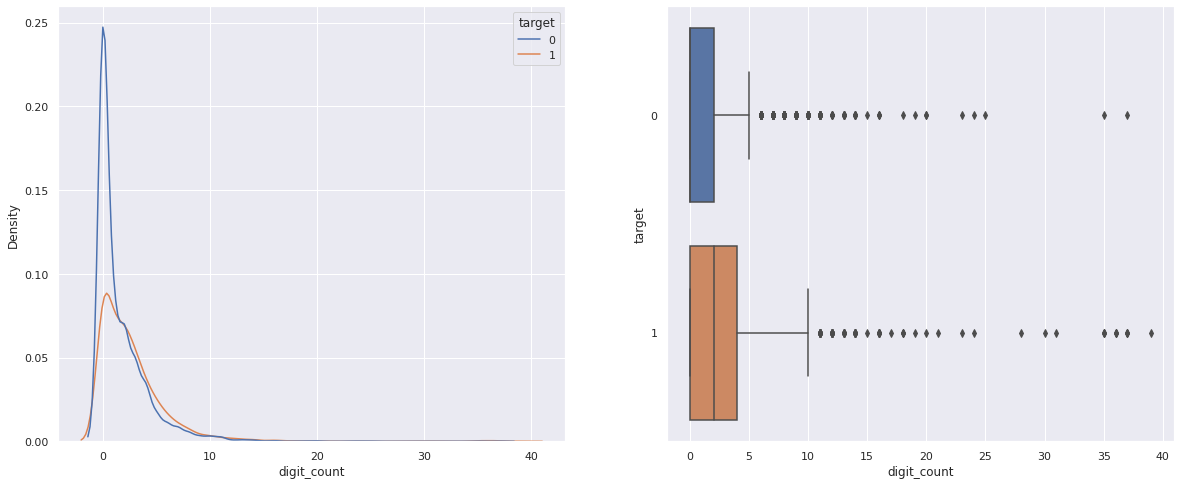

In [188]:
def get_digit_count(tweet):
  count = 0
  for c in tweet:
    if(c in string.digits):
      count+=1
  return count


df_train['digit_count'] = df_train['text'].apply(get_digit_count)
df_test['digit_count'] = df_test['text'].apply(get_digit_count)


fig,axes = plt.subplots(1,2, figsize=(20,8))
sns.kdeplot(data=df_train, x = 'digit_count', hue='target', ax=axes[0])
# sns.histplot(data=df_train, x = 'digit_count', hue='target', multiple='dodge', ax=axes[0])


sns.boxplot(data=df_train, x = 'digit_count', y='target', orient='h',ax=axes[1])

# df_train.head()

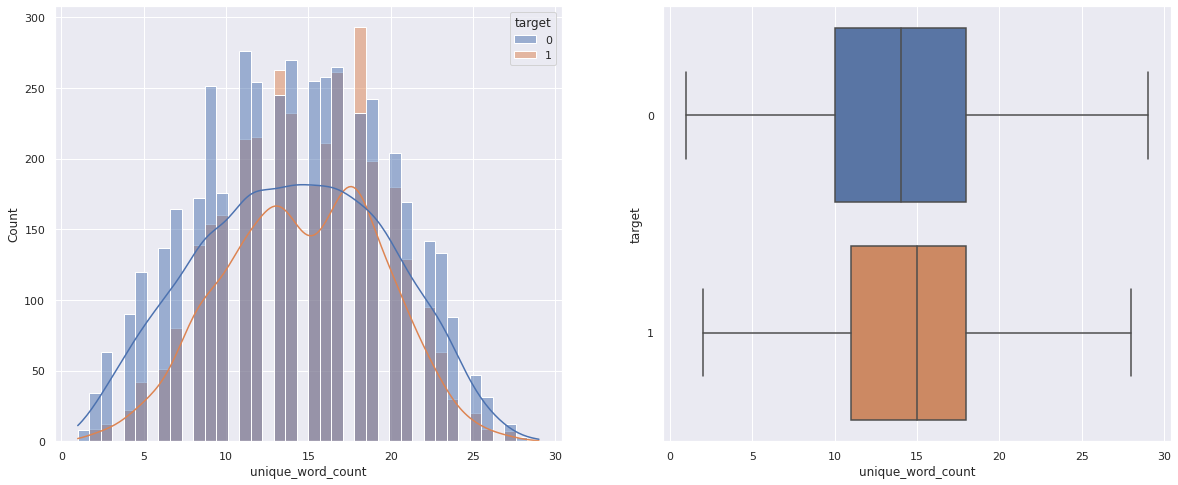

In [189]:
def get_unique_word_count(tweet):
  return len(set(tweet.split(' ')))


df_train['unique_word_count'] = df_train['text'].apply(get_unique_word_count)
df_test['unique_word_count'] = df_test['text'].apply(get_unique_word_count)

fig,axes = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data=df_train, x = 'unique_word_count', hue='target', ax=axes[0], kde=True)
sns.boxplot(data=df_train, x = 'unique_word_count', y='target', orient='h',ax=axes[1])

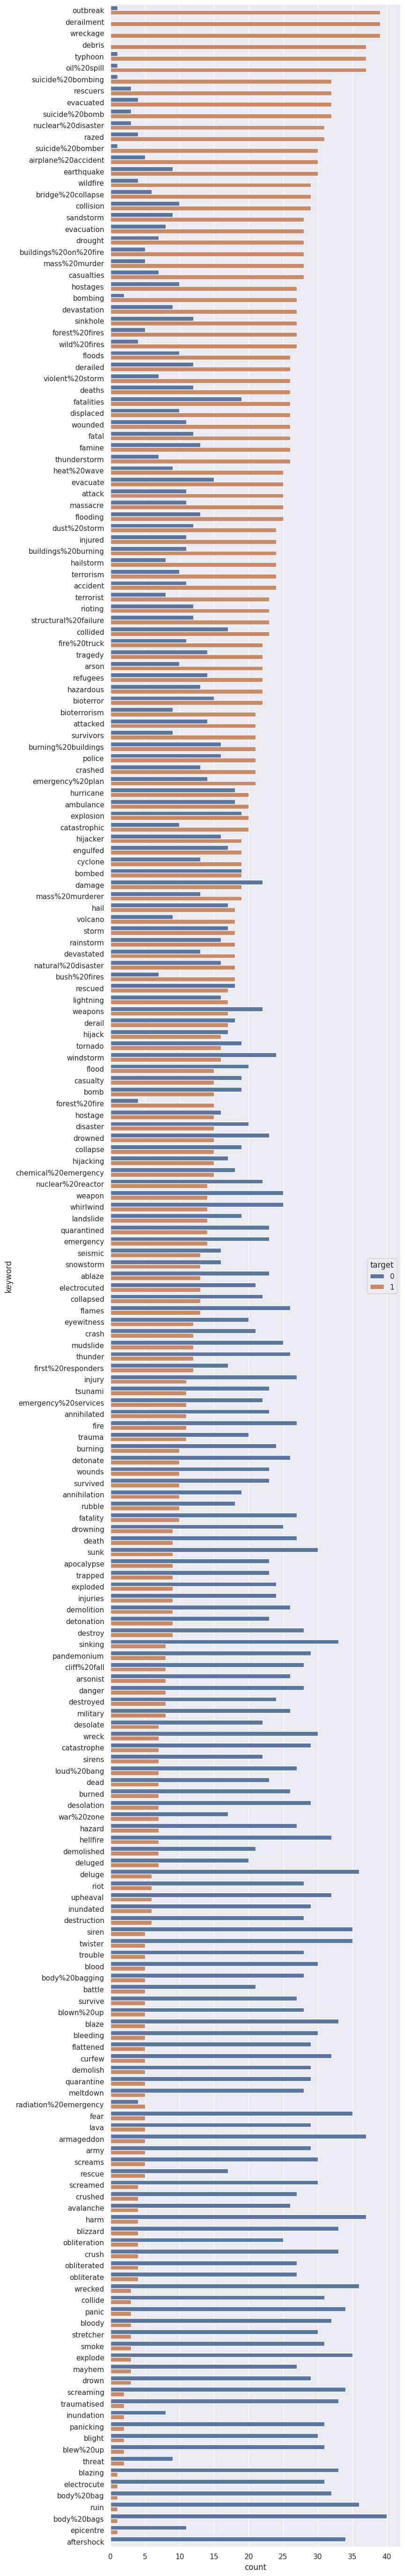

In [190]:
# df_train['keyword'].fillna('NA', inplace=True)
df_train['target_count'] = df_train.groupby('keyword')['target'].transform('sum')
df_test['target_count'] = df_test.groupby('keyword')['target'].transform('sum')


fig = plt.figure(figsize=(8, 72), dpi=100)
sns.countplot(data = df_train.sort_values(by='target_count',ascending=False), y = 'keyword',hue='target')

df_train.drop('target_count',axis=1,inplace=True)
df_test.drop('target_count',axis=1,inplace=True)


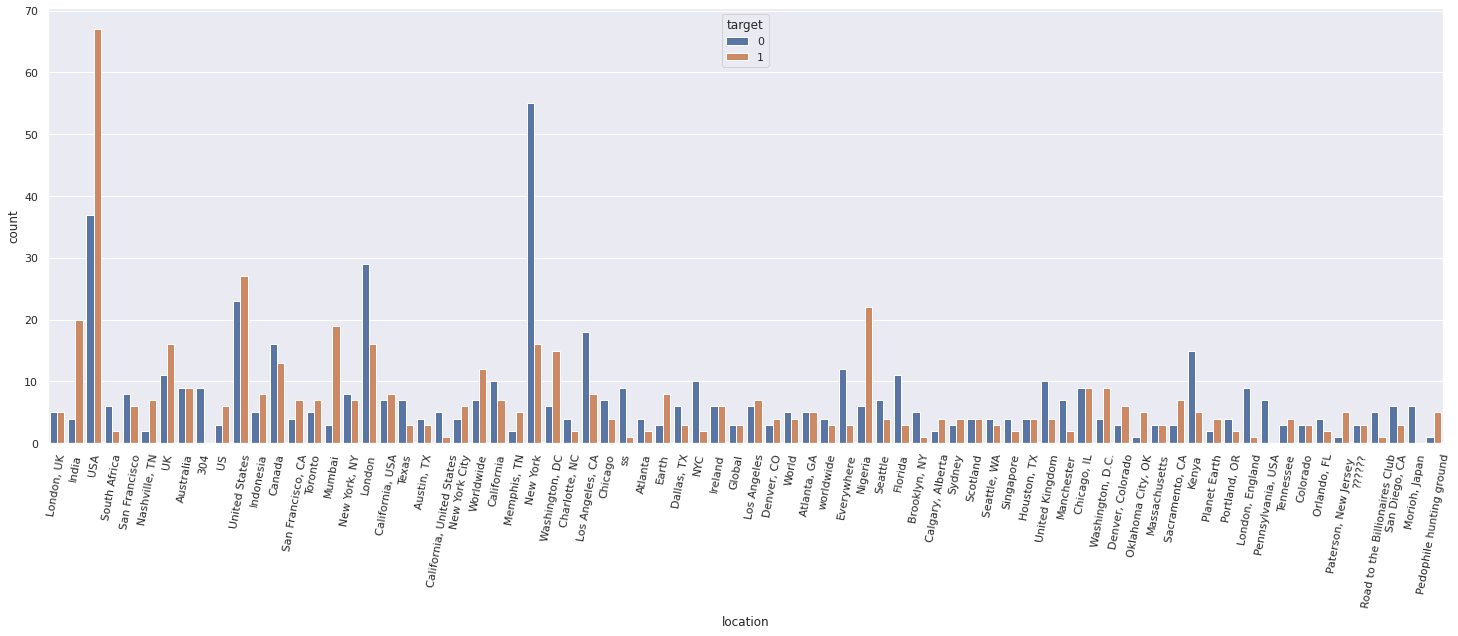

In [191]:
# df_train['location'].fillna('UNKNOWN',inplace=True)
validLocations = df_train.groupby('location').filter(lambda x: len(x) > 5)

validLocations.head()
plt.figure(figsize=(25,8))
sns.countplot(data=validLocations, x='location', hue='target')
plt.xticks(rotation=80);

# Clean up

Clean up tasks:
1. Normalization
2. Stemming #
3. Stop word Removal
4. ?

In [196]:
stopwords_eng = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def clean_tweet(tweet):

  # Normalize
  cleaned = tweet.lower()

  # Remove Stopwords and links
  cleaned = ' '.join([word for word in cleaned.split() if word not in stopwords_eng and not word.startswith('http')])

  # Remove digits and any other characters
  cleaned = ''.join([char for char in cleaned if char in string.ascii_lowercase or char == ' '])

  cleaned = lemmatize_string(cleaned)

  return cleaned


def lemmatize_string(sentence):
  return ' '.join([lemmatizer.lemmatize(word) for word in sentence.split()])

df_train['cleaned_tweet'] = df_train['text'].apply(clean_tweet)
df_test['cleaned_tweet'] = df_test['text'].apply(clean_tweet)


,id,keyword,location,text,target,len_tweet,punct_count,unique_word_count,cleaned_tweet
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1,13,deed reason earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38,1,7,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133,3,20,resident asked shelter place notified officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65,2,9,people receive wildfire evacuation order calif...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,2,16,got sent photo ruby alaska smoke wildfire pour...
...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,83,5,11,two giant crane holding bridge collapse nearby...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,125,5,17,ariaahrary thetawniest control wild fire calif...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,65,11,8,m utckm volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,137,5,19,police investigating ebike collided car little...


In [201]:
encoder = LabelEncoder()

df_train['keyword'] = encoder.fit_transform(df_train['keyword'])
df_test['keyword'] = encoder.transform(df_test['keyword'])

df_train['location'] = encoder.fit_transform(df_train['location'])
df_test['location'] = encoder.fit_transform(df_test['location'])


df_train.head()

,id,keyword,location,text,target,len_tweet,punct_count,unique_word_count,cleaned_tweet
0,1,221,3341,Our Deeds are the Reason of this #earthquake M...,1,69,1,13,deed reason earthquake may allah forgive u
1,4,221,3341,Forest fire near La Ronge Sask. Canada,1,38,1,7,forest fire near la ronge sask canada
2,5,221,3341,All residents asked to 'shelter in place' are ...,1,133,3,20,resident asked shelter place notified officer ...
3,6,221,3341,"13,000 people receive #wildfires evacuation or...",1,65,2,9,people receive wildfire evacuation order calif...
4,7,221,3341,Just got sent this photo from Ruby #Alaska as ...,1,88,2,16,got sent photo ruby alaska smoke wildfire pour...


In [211]:
vectorizer = TfidfVectorizer()

model = RandomForestClassifier()
column_transformer = ColumnTransformer(
    [('tfidf', vectorizer, 'cleaned_tweet')],
    remainder='passthrough')


X = df_train[['keyword' ,'location','len_tweet' ,'punct_count' ,'unique_word_count' ,'cleaned_tweet']]
y = df_train['target']


X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)


column_transformer.fit_transform(df_train[['keyword' ,'location' ,'target' ,'len_tweet' ,'punct_count' ,'unique_word_count' ,'cleaned_tweet']])

pipe = Pipeline([
                  ('tfidf', column_transformer),
                  ('classify', model)
                ])
pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidf',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('tfidf', TfidfVectorizer(),
                                                  'cleaned_tweet')])),
                ('classify', RandomForestClassifier())])

In [212]:
pipe.score(X_test, y_test)

0.7977941176470589